In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

In [2]:
datadir = '/data/Mercedes/'

In [3]:
train = pd.read_csv(datadir + 'train.csv')
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape

(4209, 378)

# Data Types 

In [5]:
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


# Target Variable:

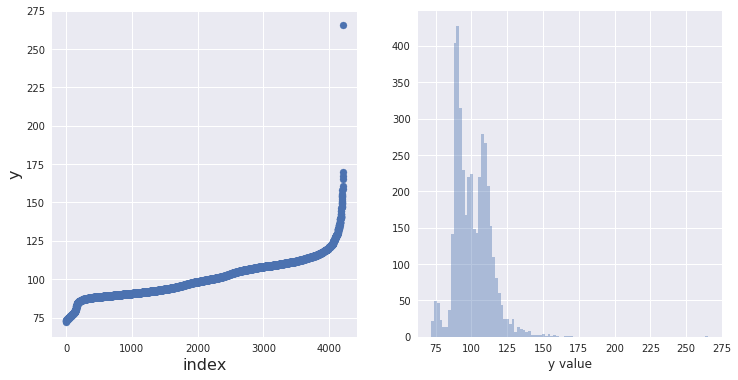

In [6]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(range(len(train)), np.sort(train.y.values))
plt.xlabel('index', fontsize=16)
plt.ylabel('y', fontsize=16)

plt.subplot(1,2,2)
sns.distplot(train.y.values, bins=100, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

In [7]:
# Only 1 instance 
train.ix[train.y>200]

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
883,1770,265.32,y,r,ai,f,d,ag,l,t,...,0,0,0,0,0,0,0,0,0,0


# Missing Values

In [8]:
miss_df = train.isnull().sum().reset_index()
miss_df.columns = ['column_name', 'missing_cnt']
miss_df.ix[miss_df['missing_cnt']>0]

,column_name,missing_cnt


No missing values !

# Categorical columns

In [9]:
dtype_df.ix[dtype_df['Column Type'] == 'object']

,Count,Column Type
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


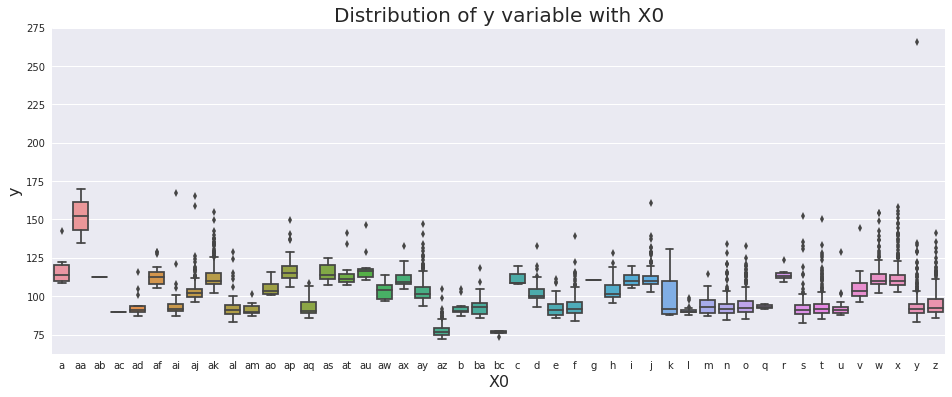

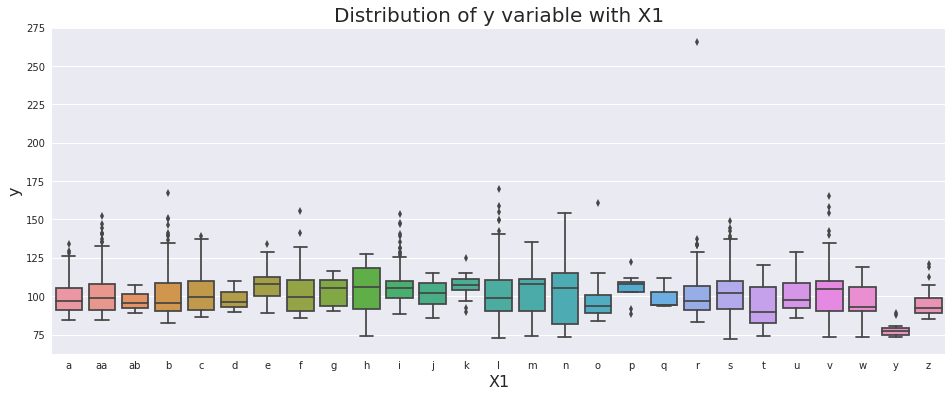

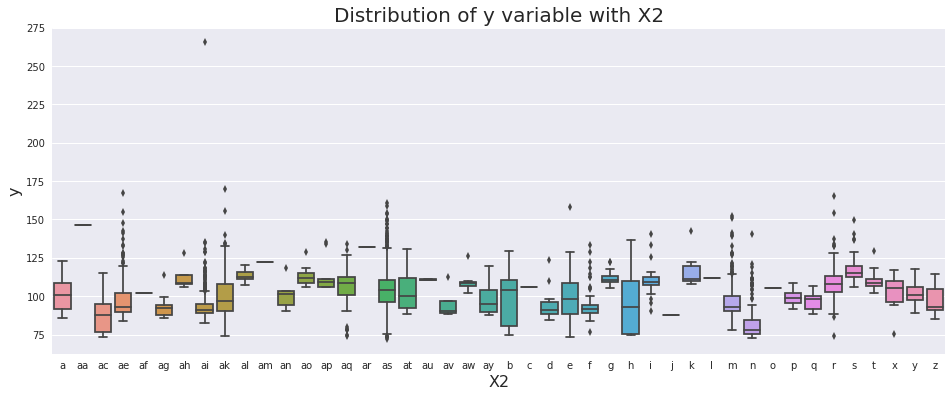

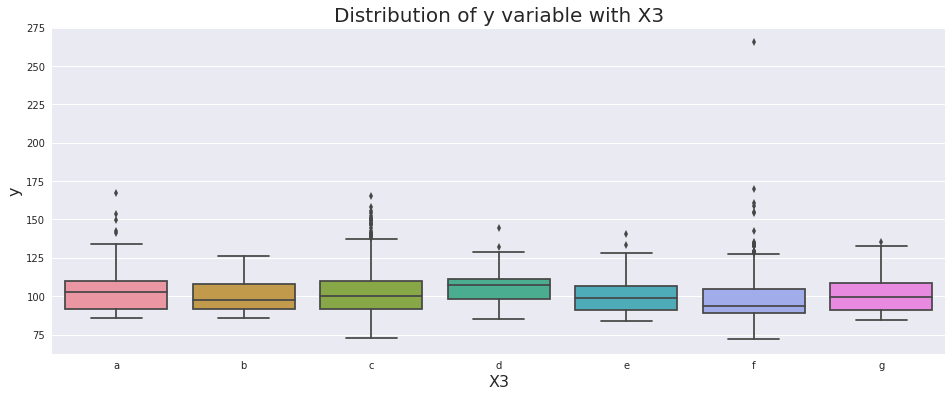

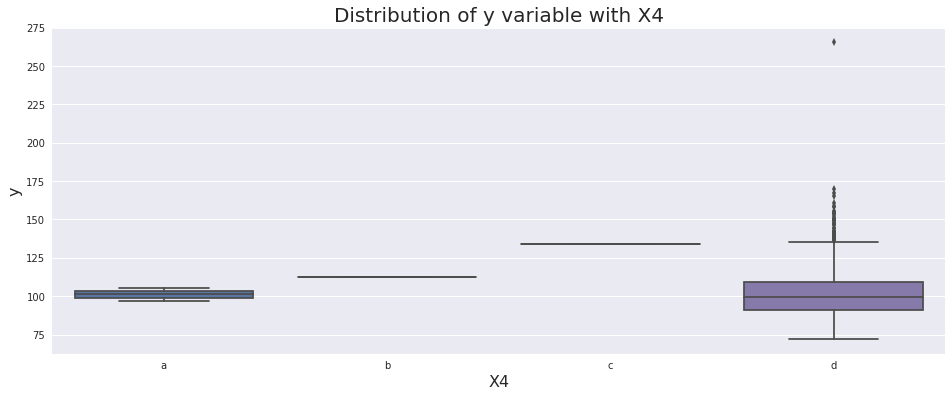

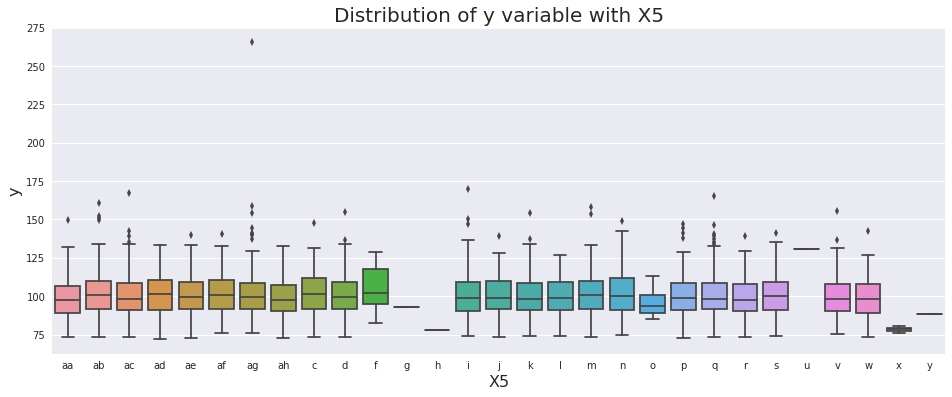

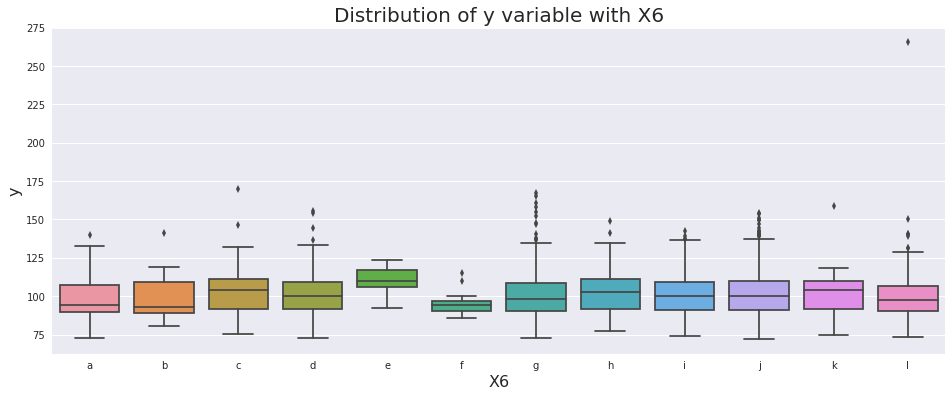

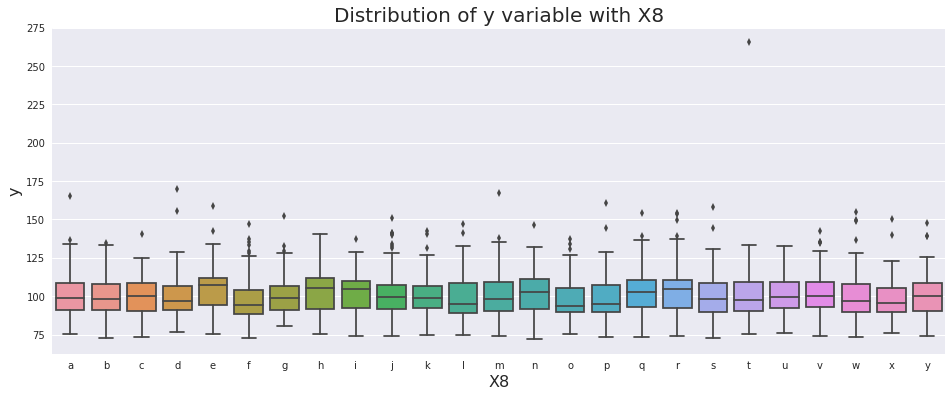

In [10]:
def boxplotVar(var_name, train):
    col_order = np.sort(train[var_name].unique()).tolist()
    plt.figure(figsize=(16,6))
    sns.boxplot(x=var_name, y='y', data=train, order=col_order)
    plt.xlabel(var_name, fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.title("Distribution of y variable with "+var_name, fontsize=20)
    plt.show()
    
boxplotVar('X0', train)
boxplotVar('X1', train)
boxplotVar('X2', train)
boxplotVar('X3', train)
boxplotVar('X4', train)
boxplotVar('X5', train)
boxplotVar('X6', train)
boxplotVar('X8', train)

# Integer Columns:

In [11]:
# Get all integer columns excludes column ID

intCol = pd.DataFrame(dtype_df.ix[dtype_df['Column Type'] == 'int64'])
intCol.columns = ['column_name', 'Column_Type']
intCol.drop([0], inplace = True) #drop the column ID
intCol.head()

,column_name,Column_Type
10,X10,int64
11,X11,int64
12,X12,int64
13,X13,int64
14,X14,int64


In [12]:
# column counts with the column unique values
def getUnique(x):
    return str(sorted(train[x].unique().tolist()))
intCol['unique_values'] = intCol["column_name"].apply(getUnique)
intCol.unique_values.value_counts()

[0, 1]    356
[0]        12
Name: unique_values, dtype: int64

There are 12 columns have only unique value 0, which could be excluded from the modeling. Others are the binary columns.

## Binary Columns:

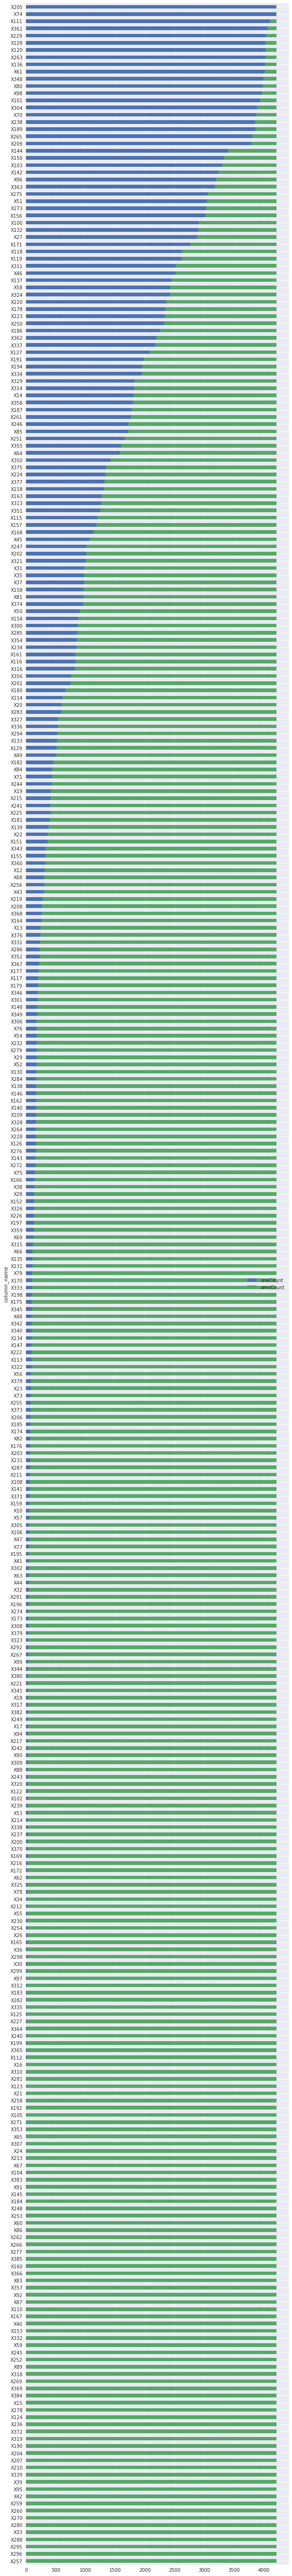

In [13]:
binaryCol = intCol.ix[intCol.unique_values == '[0, 1]']
def getOneCount(x):
    return train[x].sum()
binaryCol['oneCount'] = binaryCol['column_name'].apply(getOneCount)
binaryCol['zeroCount'] = len(train) - binaryCol['oneCount']
binaryCol.sort_values(by='oneCount',inplace = True)

binaryCol.index = binaryCol.column_name
binaryCol[['oneCount','zeroCount']].plot(figsize=(10,100), kind='barh', stacked = True)
plt.show()

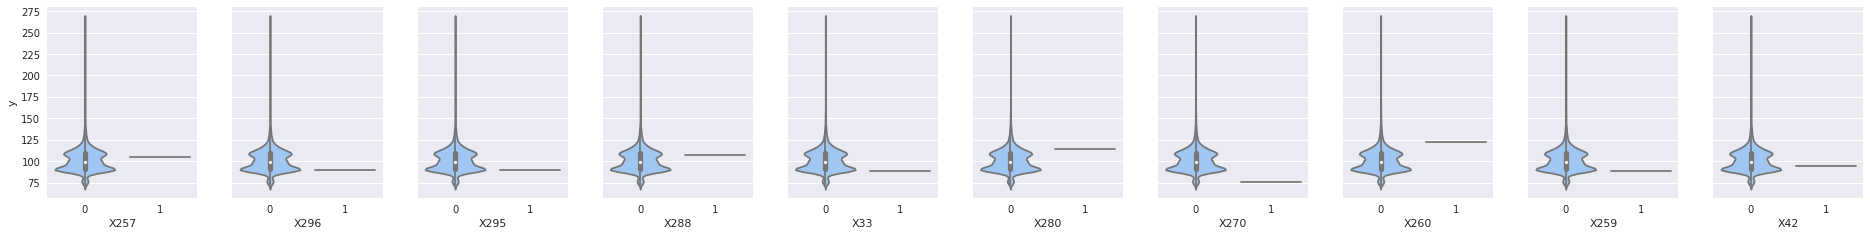

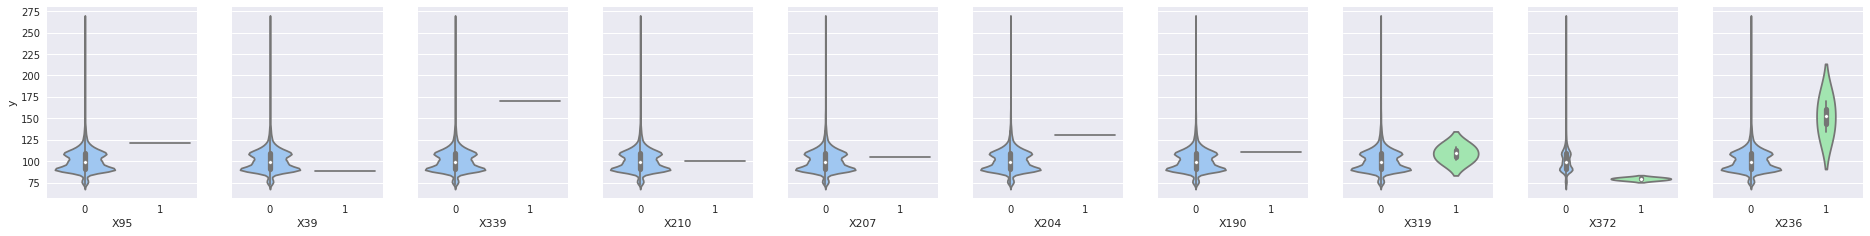

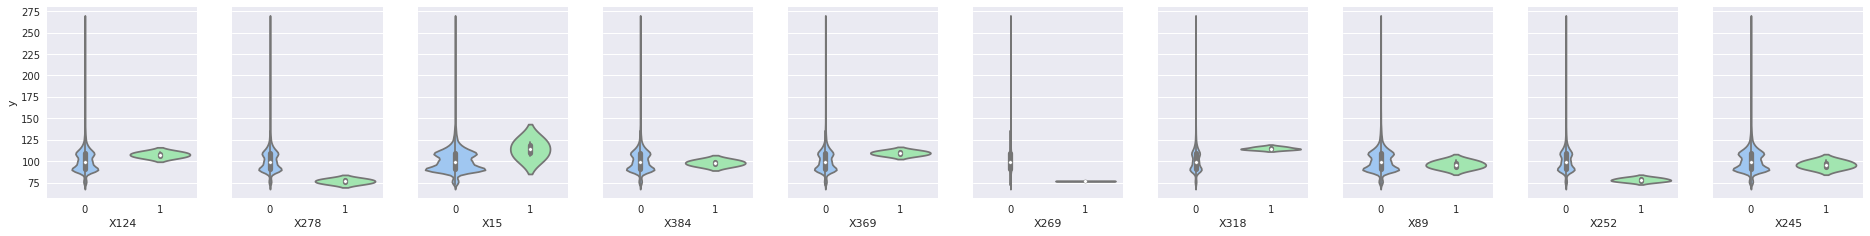

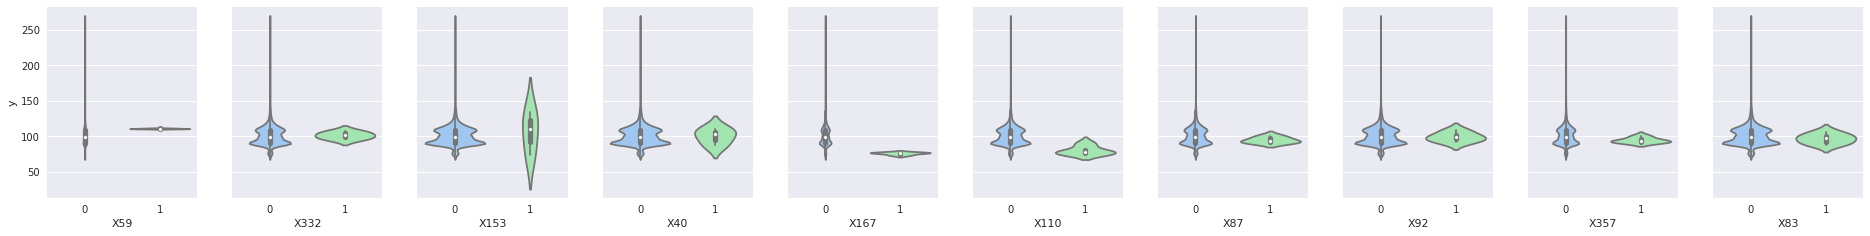

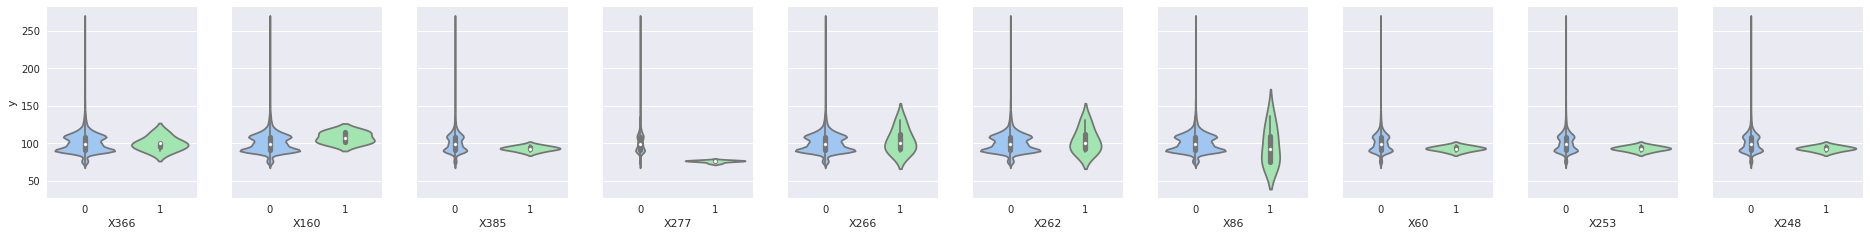

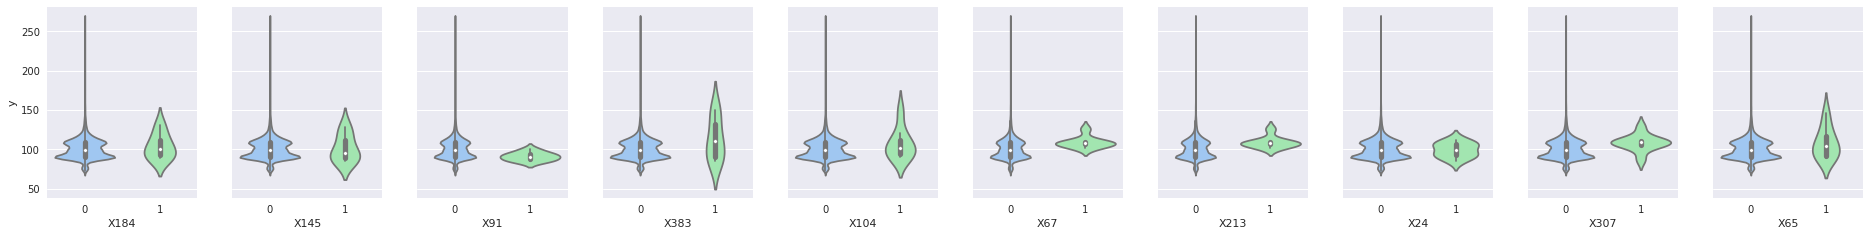

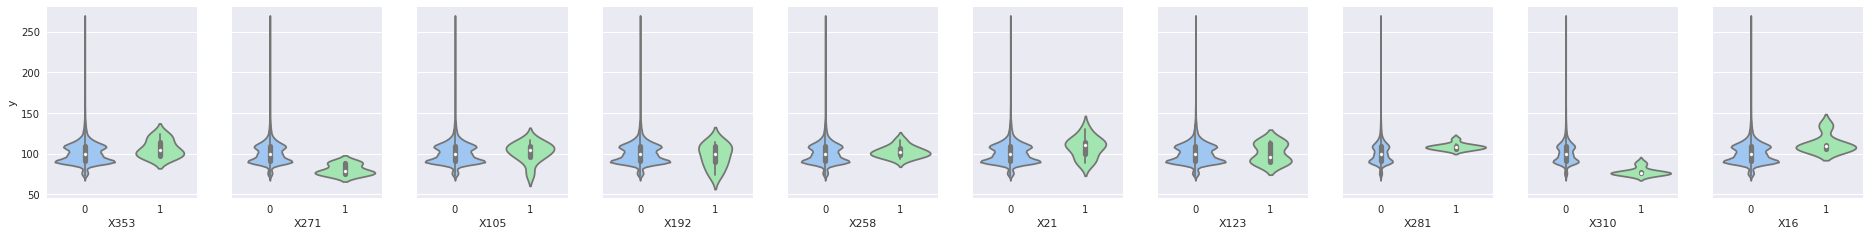

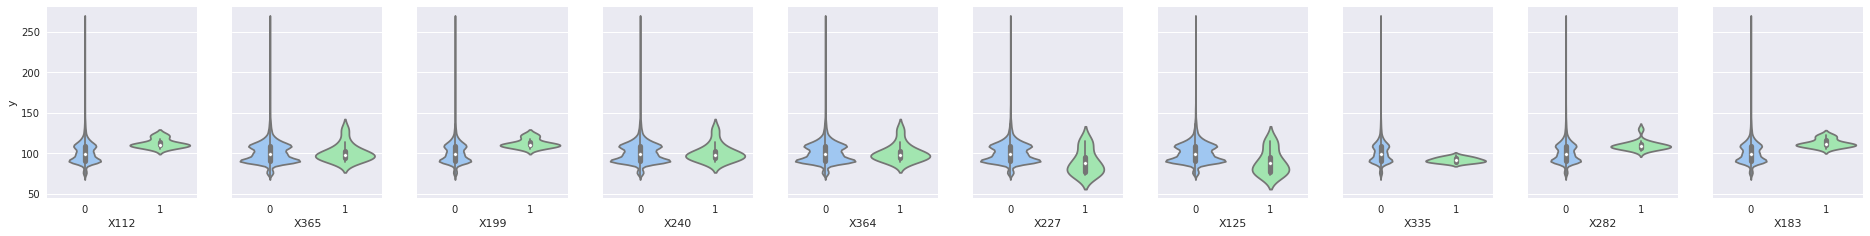

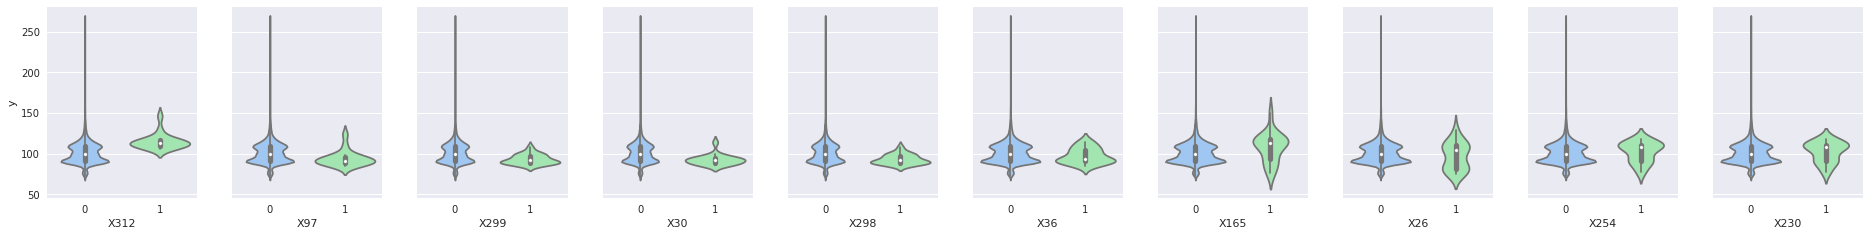

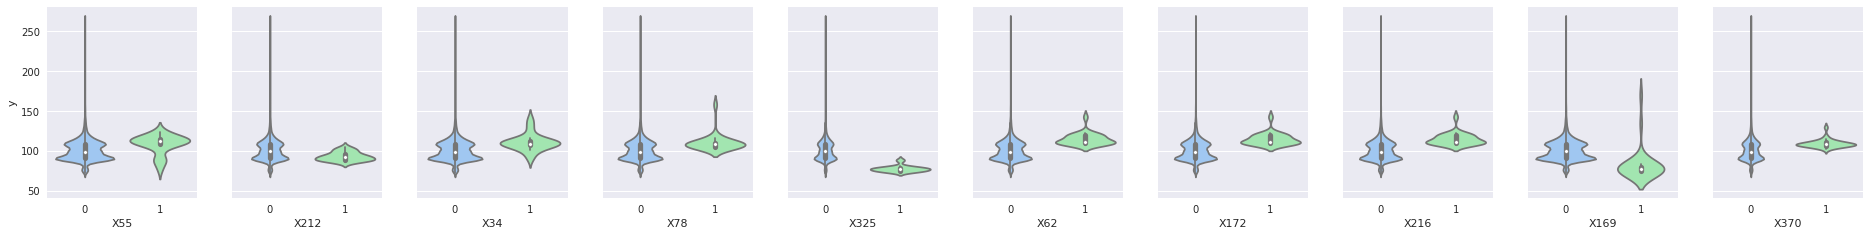

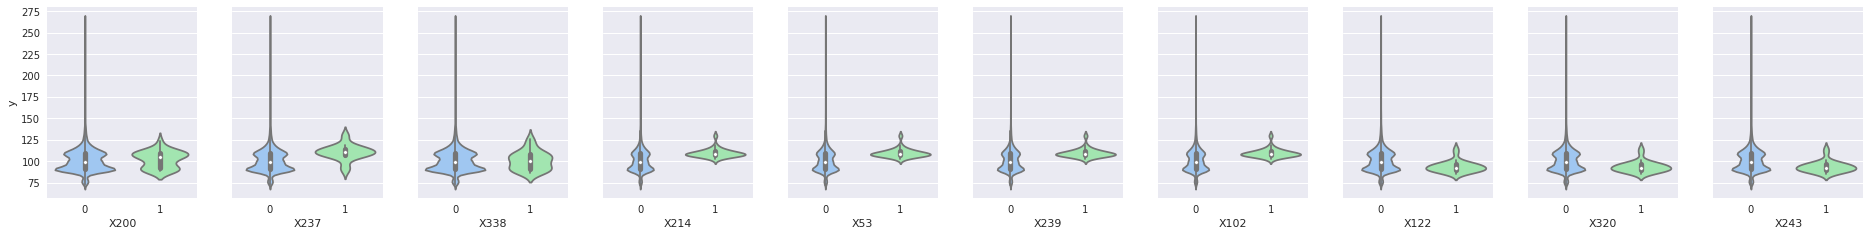

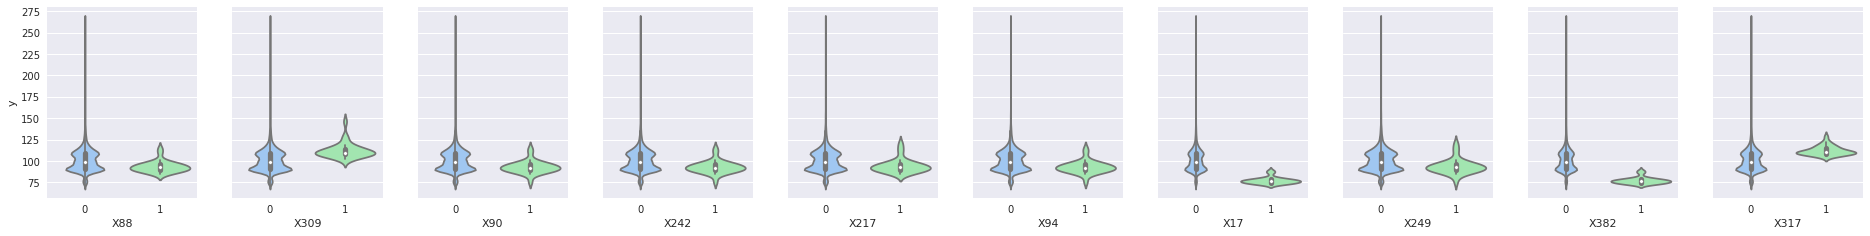

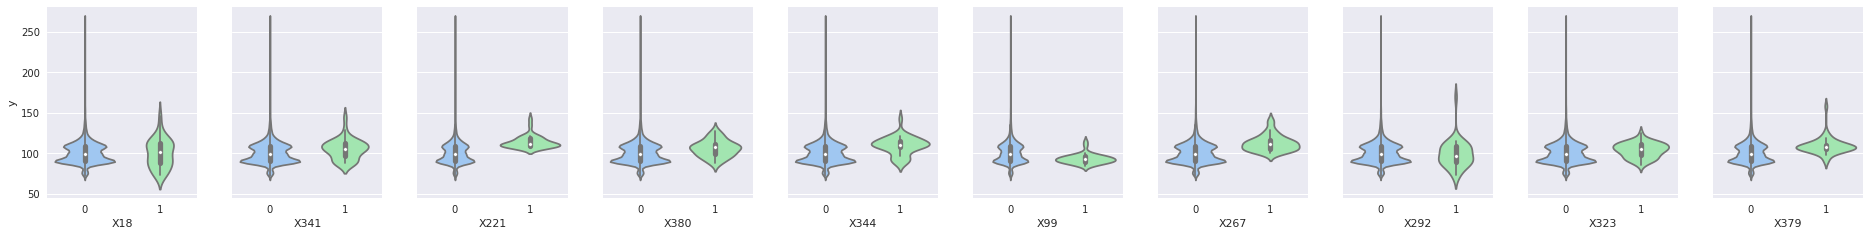

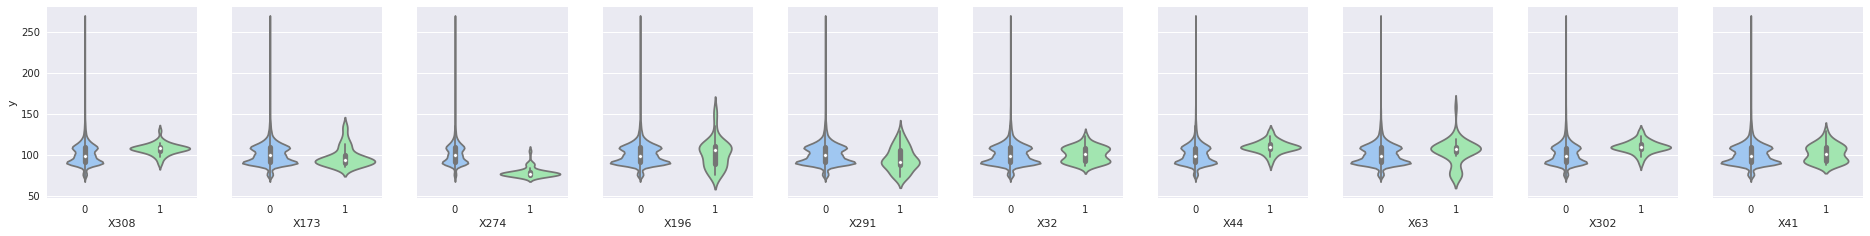

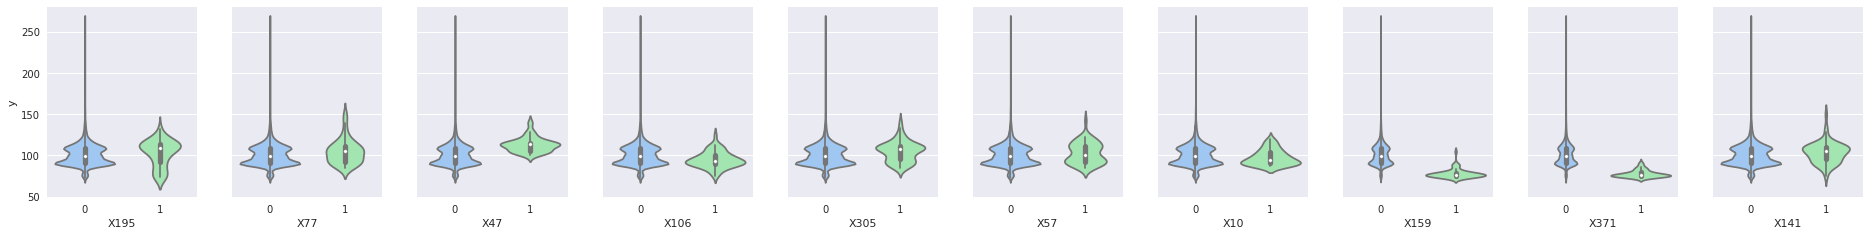

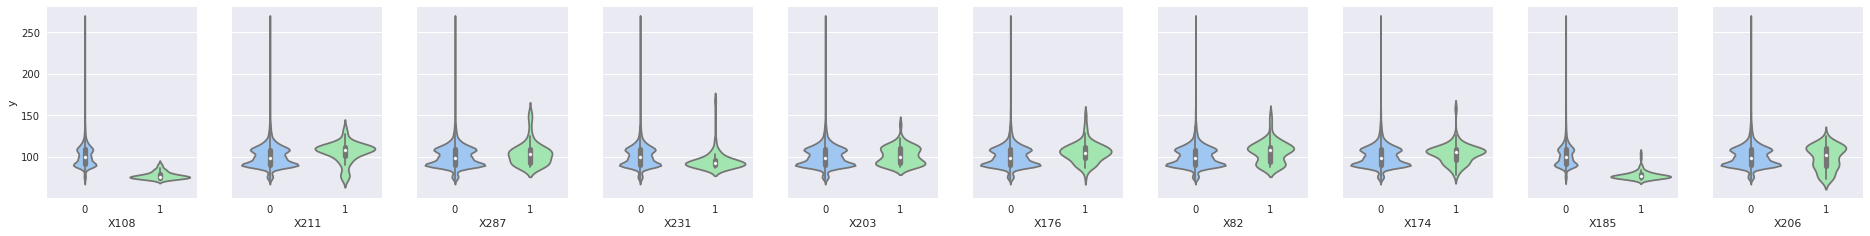

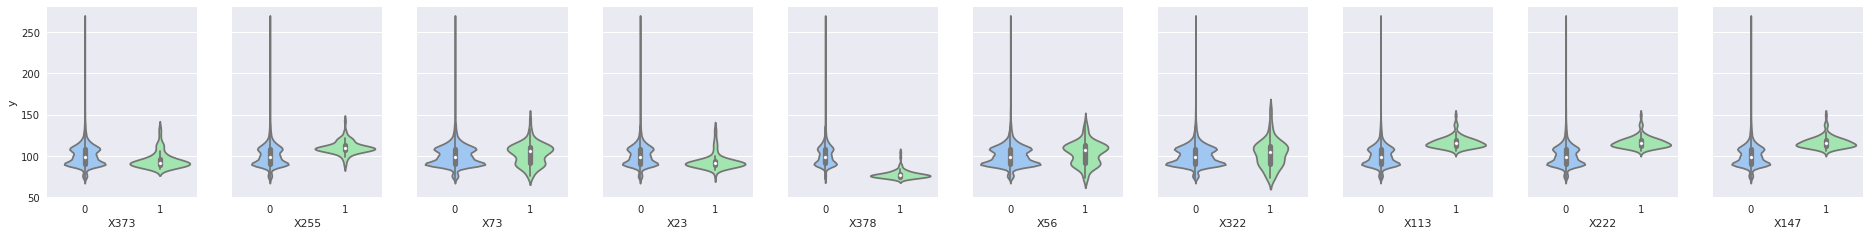

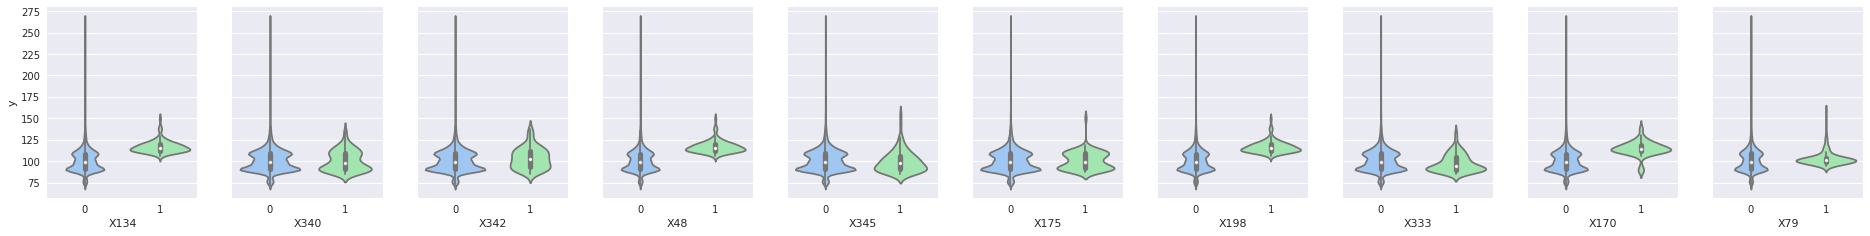

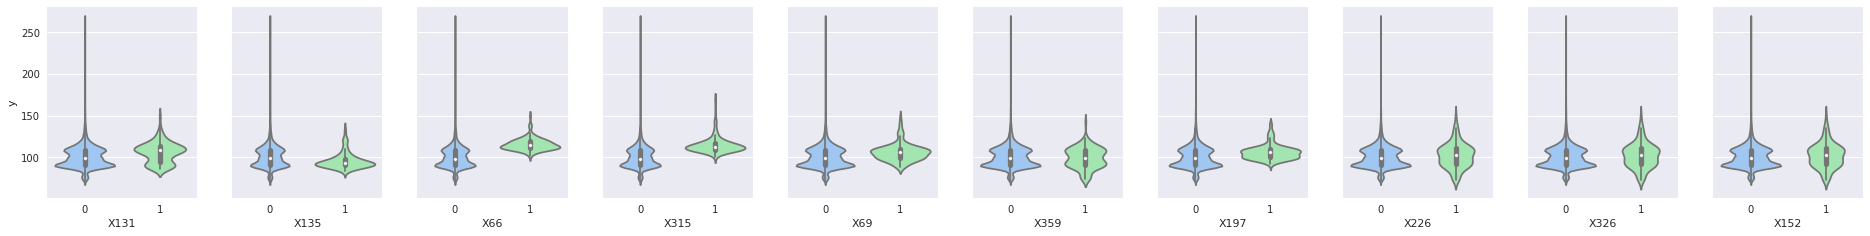

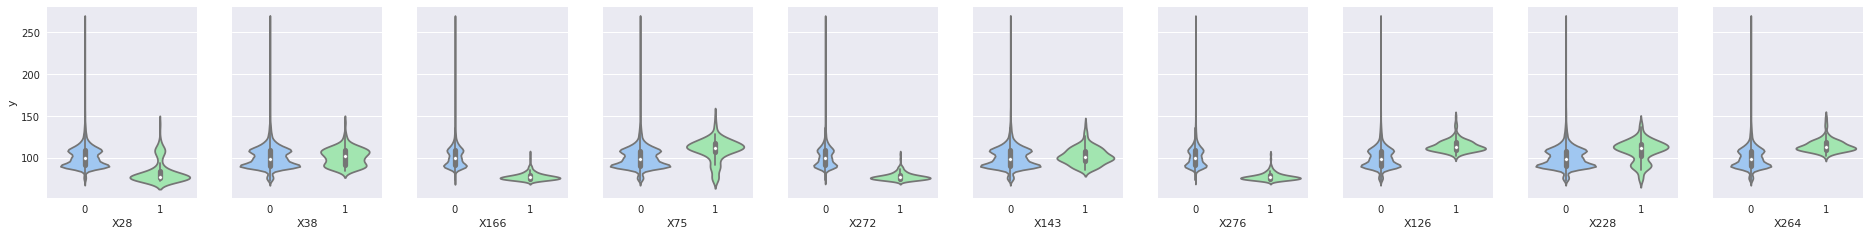

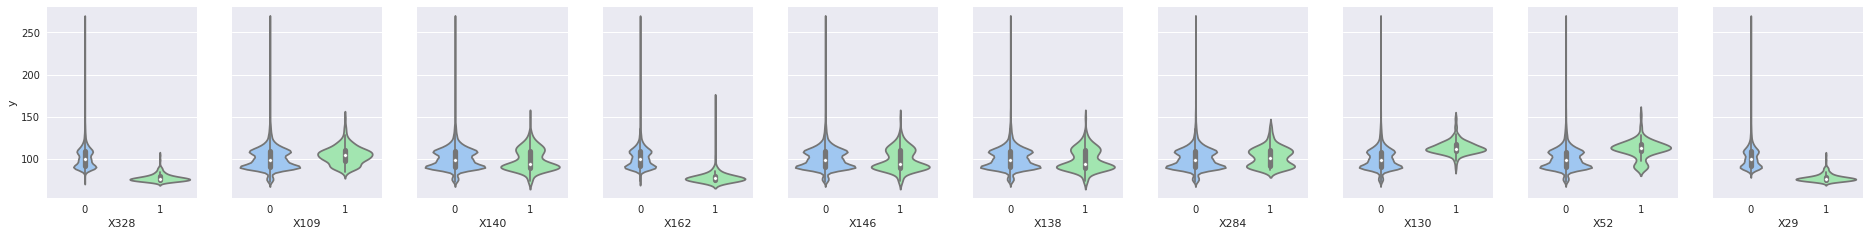

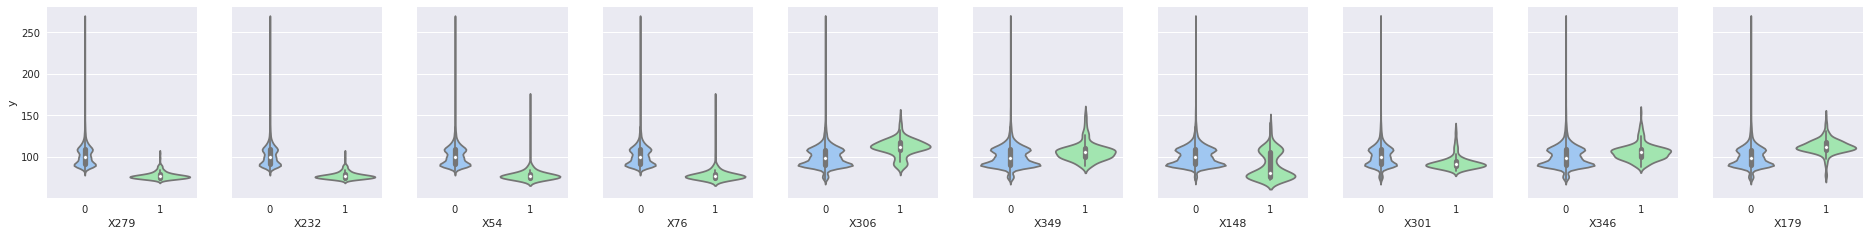

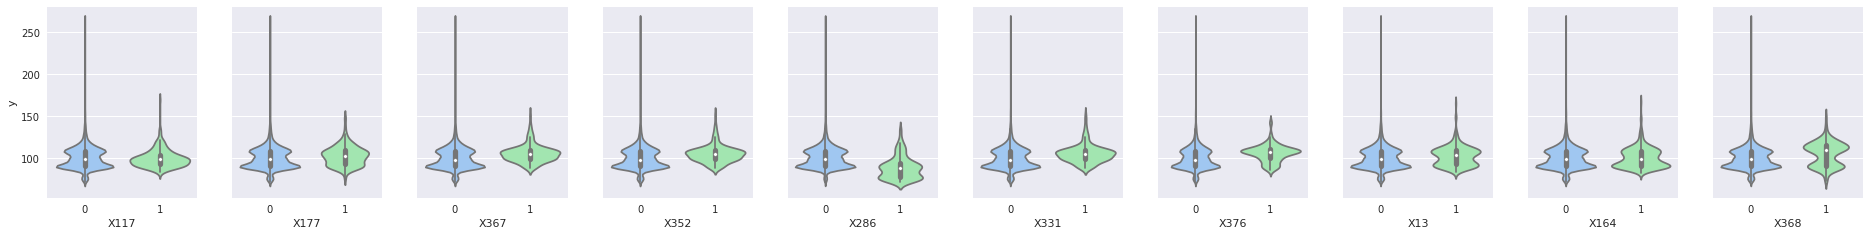

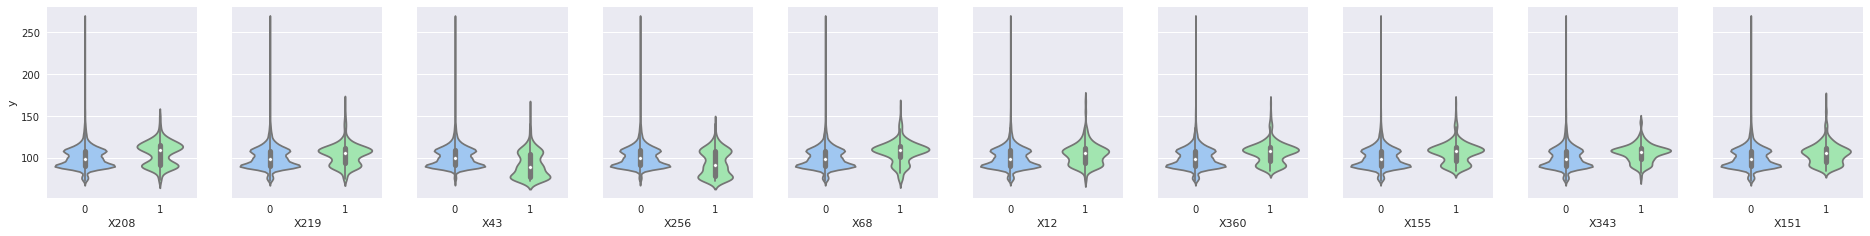

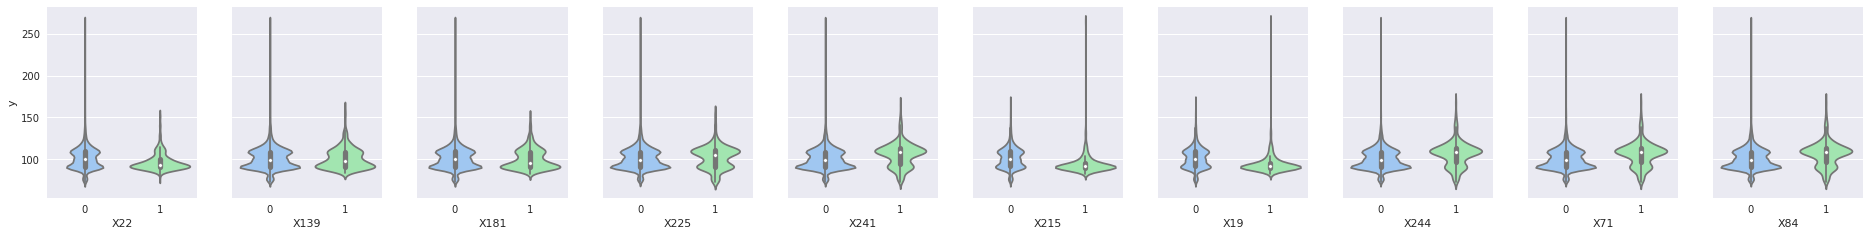

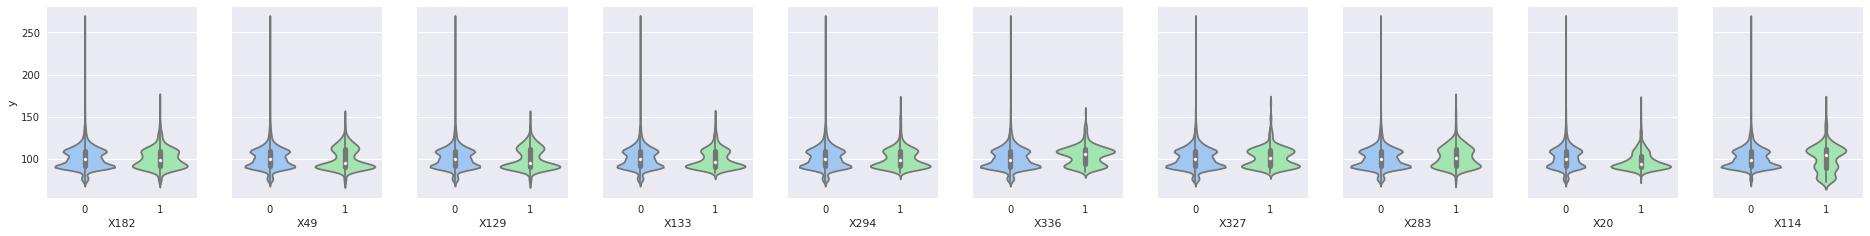

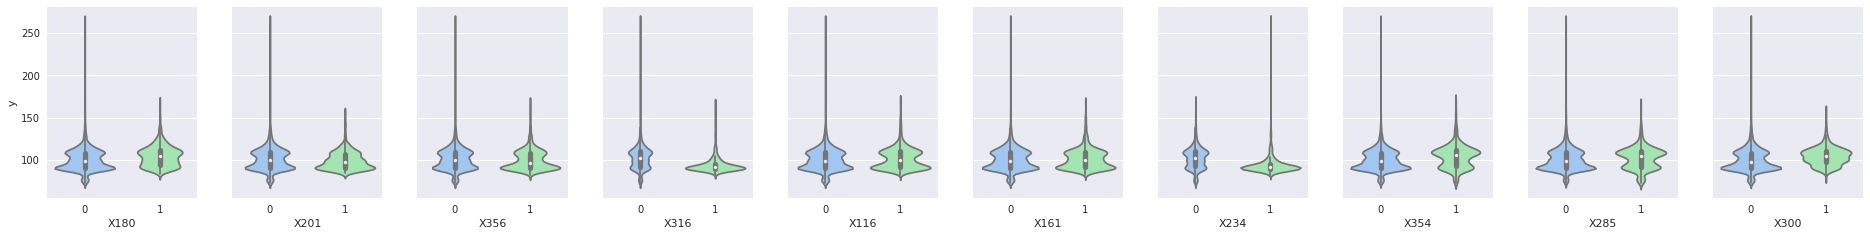

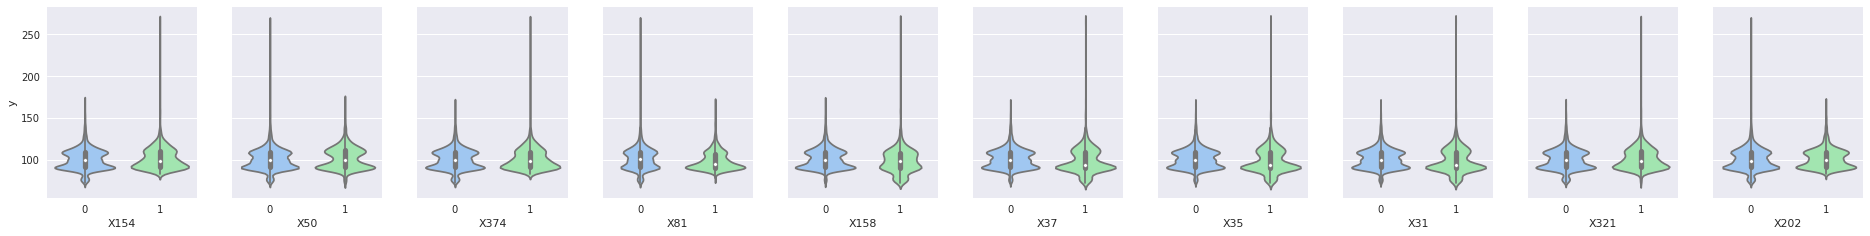

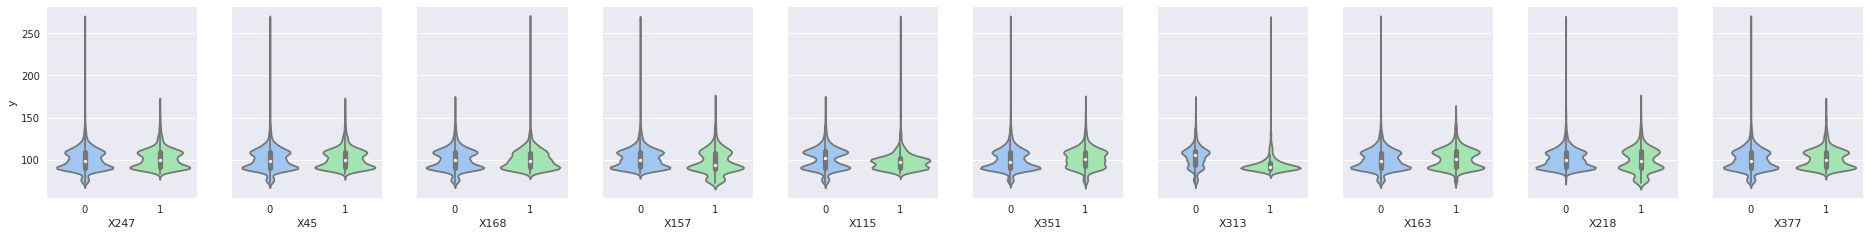

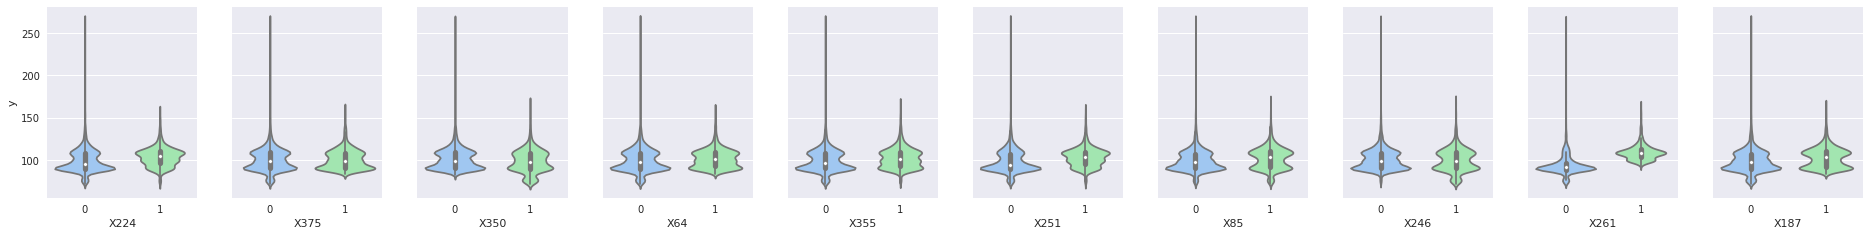

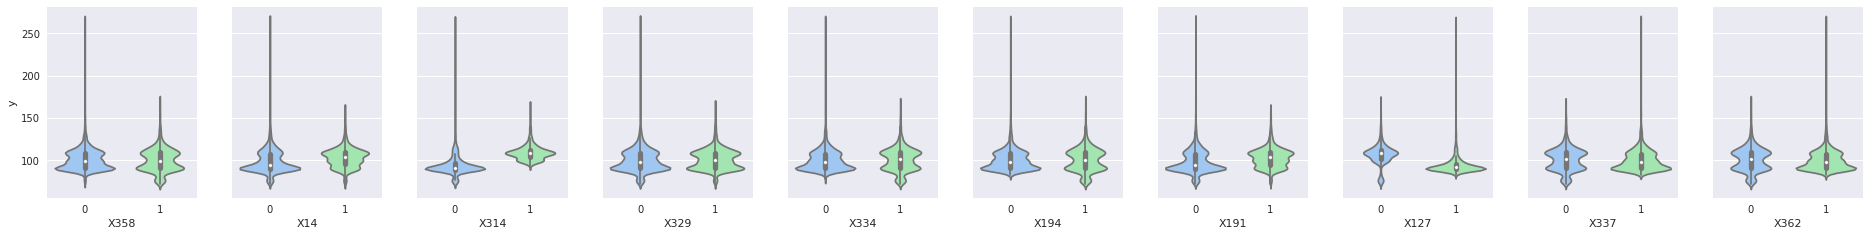

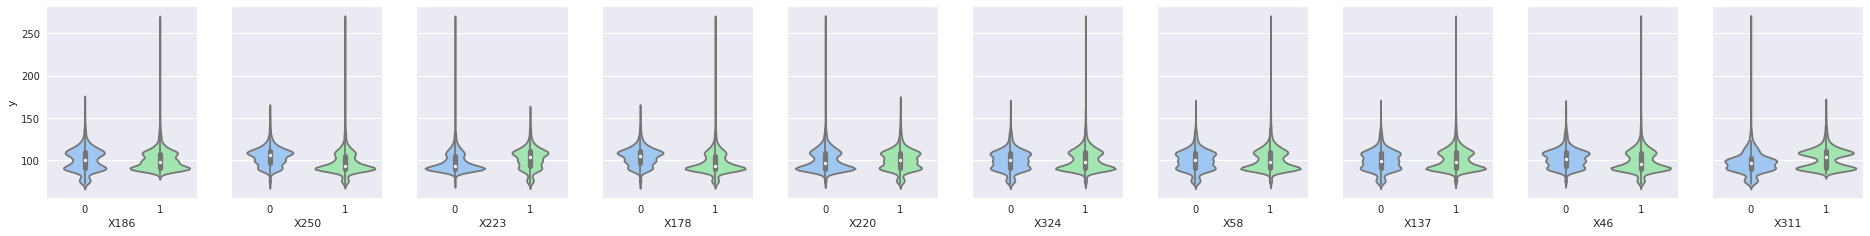

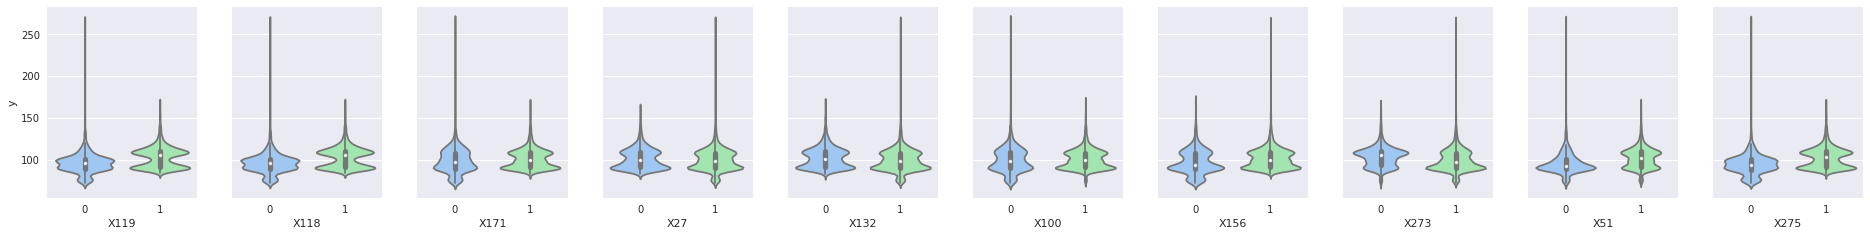

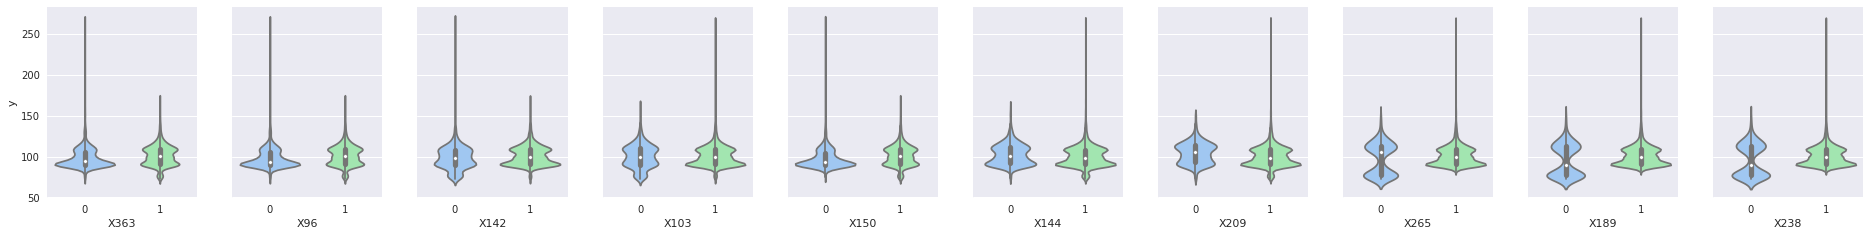

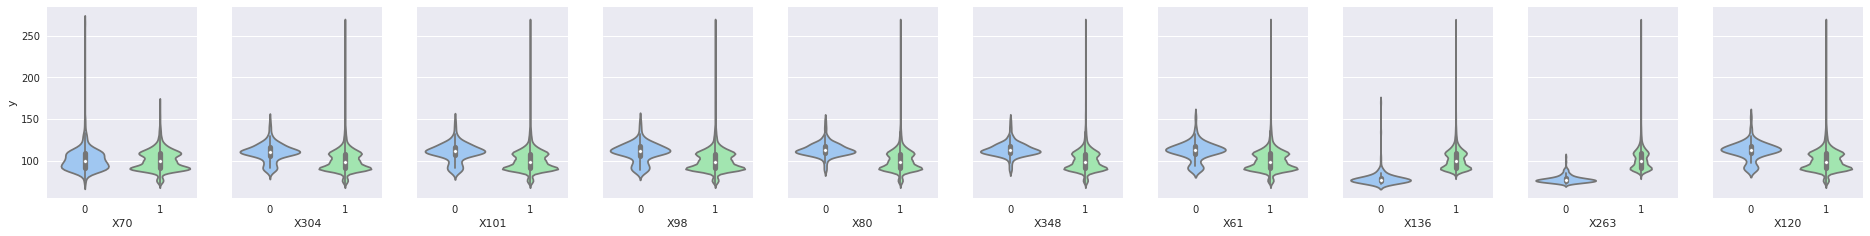

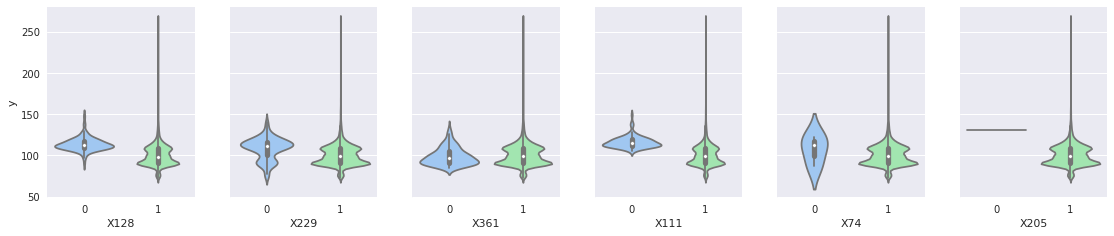

In [14]:
for i in range(36):
    ii = list(range(i*10,min(i*10+10, len(binaryCol))))
    cols = binaryCol.column_name[ii]
    g = sns.PairGrid(train,
                 x_vars=cols,
                 y_vars=["y"],
                 aspect=.75, size=3.5)
    g.map(sns.violinplot, palette="pastel")

# Important Variables:

In [15]:
# drop the columns with only 0 values and onehot encoder for the categorical columns
zeroCol = intCol.ix[intCol.unique_values == '[0]'].column_name
train.drop(zeroCol, axis = 1, inplace = True)
train_y = train.y.values
train.drop(['ID','y'], axis = 1 , inplace = True)
train_x =  pd.get_dummies(train, drop_first=True)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


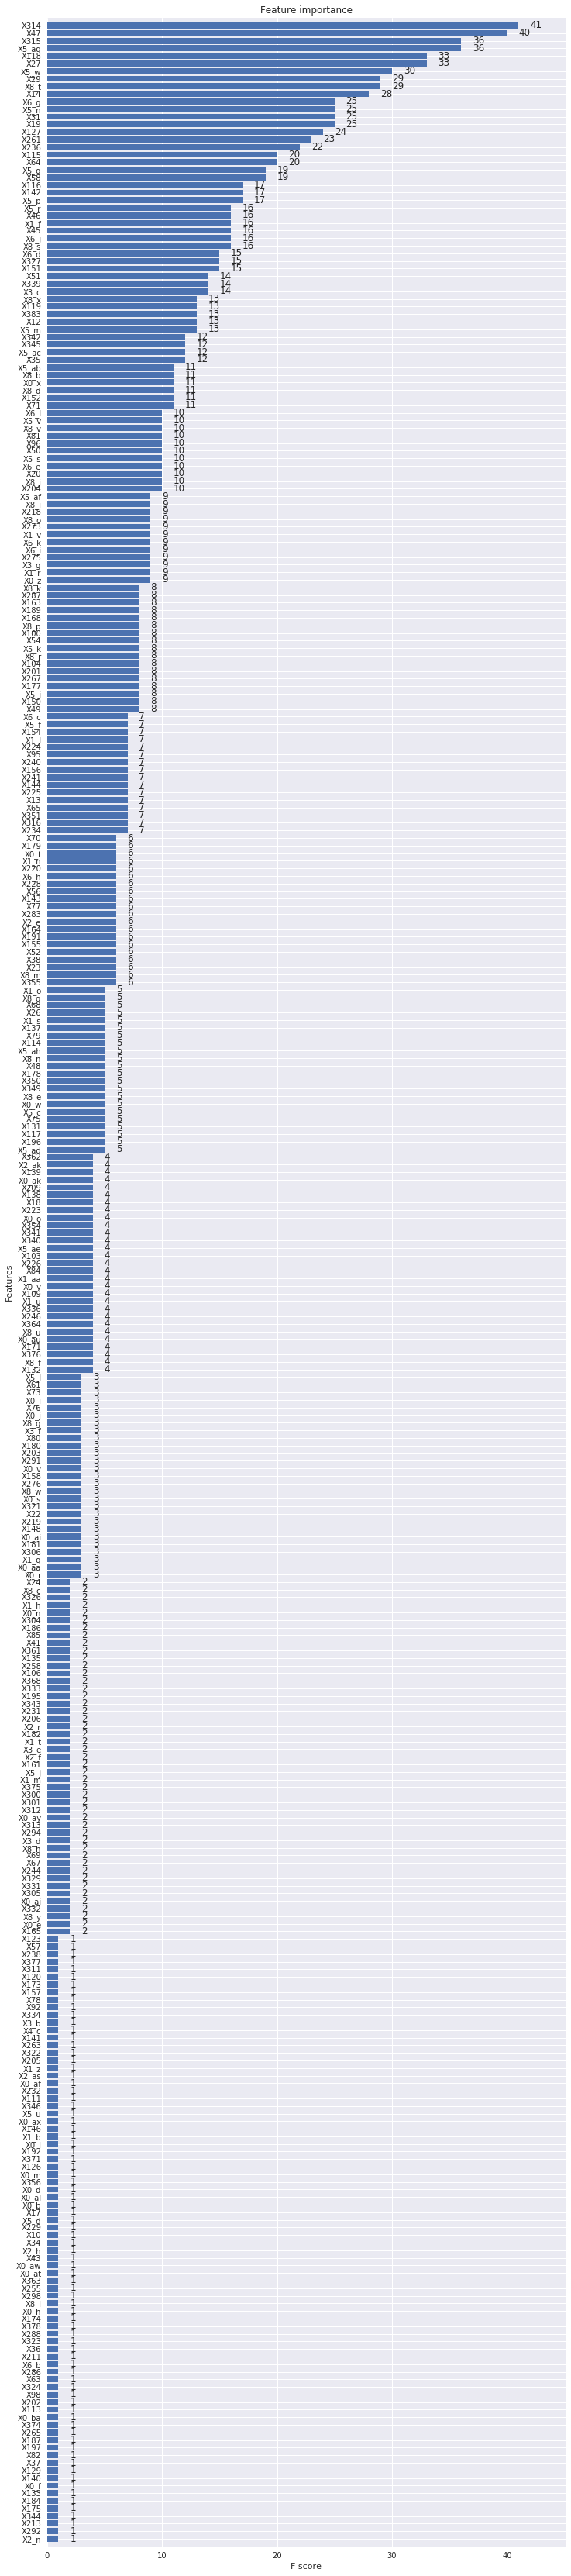

In [16]:
import xgboost as xgb
def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'silent': 1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names=train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize=True)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,60))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

# PCA 

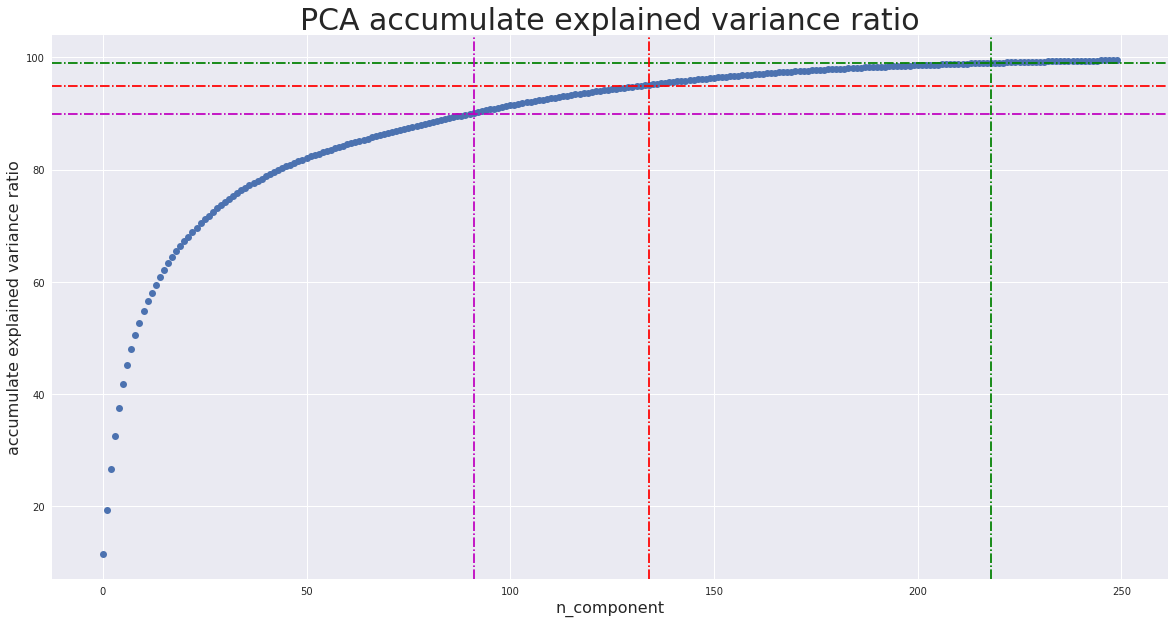

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components = 250)
pca.fit(train_x)

import numpy 
tot = numpy.cumsum(pca.explained_variance_ratio_)*100
plt.figure(figsize = (20,10))
plt.plot(tot,'o')
plt.axhline(y=95, color='r', linestyle = '-.')
plt.axhline(y=90, color='m', linestyle = '-.')
plt.axhline(y=99 ,color='g',linestyle = '-.')
plt.axvline(x=91, color='m', linestyle = '-.')
plt.axvline(x=134, color='r', linestyle = '-.')
plt.axvline(x=218, color='g', linestyle = '-.')
plt.title('PCA accumulate explained variance ratio', fontsize = 30)
plt.xlabel('n_component', fontsize = 16)
plt.ylabel('accumulate explained variance ratio', fontsize = 16)
plt.show()